In [382]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split, StratifiedKFold

In [383]:
df = pd.read_csv("../input/movie-posters/data/data.csv", dtype=str)
print(df.head())

                       title          id
0                   Eksi Bir   8960040_t
1  Mein Freund, der Deutsche   8595106_t
2                    Tähminä   1266112_t
3                     Sarhos   7147756_t
4              Tamiri Mümkün  24517988_t


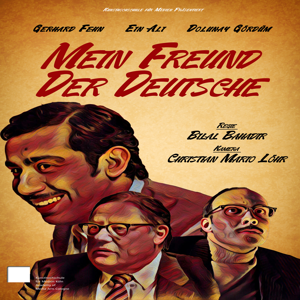

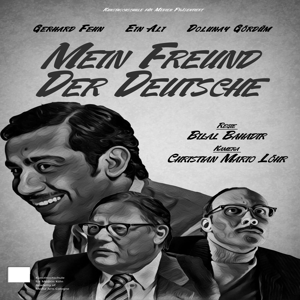

In [384]:
def display_image(image):
    plt.imshow(image.permute(1, 2, 0), cmap='gray')
    plt.axis('off')
    plt.show()
    
def display_image_from_id(image_id, color='c', size=(300, 300)):
    if color == 'b':
        image_path = "../input/movie-posters/data/images_black/" + image_id + ".jpg"
        img = Image.open(image_path)
    else:
        image_path = "../input/movie-posters/data/images_color/" + image_id + ".jpg"
        img = Image.open(image_path)
    img = img.resize(size)
    display(img)
    
display_image_from_id('8595106_t', 'c')
display_image_from_id('8595106_t', 'b')

In [385]:
class PhotoDataset(Dataset):
    def __init__(self, root_dir='../input/movie-posters/data/', df=None, device=torch.device("cuda" if torch.cuda.is_available() else "cpu")):
        self.root_dir = root_dir
        self.df = df.reset_index(drop=True)
        self.device = device
        self.to_tensor = transforms.ToTensor()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        label_path = os.path.join(self.root_dir, 'images_color', self.df['id'][idx] + '.jpg')
        image_path = os.path.join(self.root_dir, 'images_black', self.df['id'][idx] + '.jpg')

        try:
            label = Image.open(label_path)
            image = Image.open(image_path)
        except PIL.Image.DecompressionBombError:
            print(f"Skipping image {self.df['id'][idx]} due to DecompressionBombError.")
            return None, None

        label = self.to_tensor(label).to(self.device)
        image = self.to_tensor(image).to(self.device)

        image = transforms.ToPILImage()(image)
        label = transforms.ToPILImage()(label)

        return image, label

def custom_collate(batch):
    images, labels = zip(*batch)

    target_size = (256, 256)
    
    images = [transforms.Resize(target_size)(image) for image in images]
    images = [transforms.Grayscale(num_output_channels=1)(image) for image in images]
    images = [transforms.ToTensor()(image).to(device) for image in images]

    labels = [transforms.Resize(target_size)(label) for label in labels]
    labels = [np.array(label)[:, :, :3] if len(np.array(label).shape) == 3 else np.repeat(np.array(label)[:, :, None], 3, axis=2) for label in labels]
    labels = [transforms.ToTensor()(label).to(device) for label in labels]

    return torch.stack(images), torch.stack(labels)


photo_dataset = PhotoDataset(df=df)
batch_size = 4
dataloader = DataLoader(photo_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate)

In [386]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ColorizationModel(nn.Module):
    def __init__(self):
        super(ColorizationModel, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=2),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, padding=1, stride=2),
            nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, padding=1, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, padding=1, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=3, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
def train_model(model, dataloader_train, dataloader_val, criterion, optimizer, device, num_epochs=3):
    model.to(device)
    
    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0

        for idx, batch in enumerate(dataloader_train):
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()

        history['train_loss'].append(train_loss / len(dataloader_train))

        model.eval()
        with torch.no_grad():
            val_loss = 0.0
            for idx, batch in enumerate(dataloader_val):
                inputs, targets = batch
                inputs, targets = inputs.to(device), targets.to(device)

                outputs = model(inputs)

                val_loss += criterion(outputs, targets).item()

            avg_val_loss = val_loss / len(dataloader_val)
            history['val_loss'].append(avg_val_loss)

            avg_val_loss = val_loss / len(dataloader_val)
            print(f"Epoch: {epoch + 1}, Validation Loss: {avg_val_loss}")
            
    return history

def prepare_data(df, batch_size=5, test_size=0.3, random_state=42):
    df_train, df_temp = train_test_split(df, test_size=test_size, random_state=random_state)
    df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=random_state)

    photo_dataset_train = PhotoDataset(df=df_train)
    photo_dataset_val = PhotoDataset(df=df_val)
    photo_dataset_test = PhotoDataset(df=df_test)

    dataloader_train = DataLoader(photo_dataset_train, batch_size=batch_size, shuffle=True, collate_fn=custom_collate)
    dataloader_val = DataLoader(photo_dataset_val, batch_size=batch_size, shuffle=False, collate_fn=custom_collate)
    dataloader_test = DataLoader(photo_dataset_test, batch_size=batch_size, shuffle=False, collate_fn=custom_collate)

    return dataloader_train, dataloader_val, dataloader_test

In [387]:
dataloader_train, dataloader_val, dataloader_test = prepare_data(df[0:100])
model = ColorizationModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 3
training_history = train_model(model, dataloader_train, dataloader_val, criterion, optimizer, device, num_epochs=3)

Epoch: 1, Validation Loss: 0.030136387795209885
Epoch: 2, Validation Loss: 0.02611962767938773
Epoch: 3, Validation Loss: 0.02159833845992883


In [388]:
dataloader_train, dataloader_val, dataloader_test = prepare_data(df[0:100])
model = ColorizationModel().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
num_epochs = 3
training_history = train_model(model, dataloader_train, dataloader_val, criterion, optimizer, device, num_epochs=3)

Epoch: 1, Validation Loss: 0.1542147696018219
Epoch: 2, Validation Loss: 0.08699551969766617
Epoch: 3, Validation Loss: 0.08675343791643779


In [389]:
dataloader_train, dataloader_val, dataloader_test = prepare_data(df[0:100])
model = ColorizationModel().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01, lr_decay=0, weight_decay=0, initial_accumulator_value=0)
num_epochs = 3
training_history = train_model(model, dataloader_train, dataloader_val, criterion, optimizer, device, num_epochs=3)

Epoch: 1, Validation Loss: 0.04188642899195353
Epoch: 2, Validation Loss: 0.02724188317855199
Epoch: 3, Validation Loss: 0.025347384934624035


In [390]:
dataloader_train, dataloader_val, dataloader_test = prepare_data(df[0:100], 10)
model = ColorizationModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 3
training_history = train_model(model, dataloader_train, dataloader_val, criterion, optimizer, device, num_epochs=3)

Epoch: 1, Validation Loss: 0.06465800479054451
Epoch: 2, Validation Loss: 0.02947204653173685
Epoch: 3, Validation Loss: 0.027876795269548893


In [391]:
def save_model(model, filepath):
    torch.save(model.state_dict(), filepath)
    print(f"Model saved to {filepath}")

def load_model(model, filepath, device=torch.device("cuda" if torch.cuda.is_available() else "cpu")):
    model.load_state_dict(torch.load(filepath, map_location=device))
    model.to(device)
    print(f"Model loaded from {filepath}")
    return model

In [392]:
save_model(model, '/kaggle/working/model.pth')

Model saved to /kaggle/working/model.pth


In [393]:
loaded_model = load_model(ColorizationModel(), '/kaggle/working/model.pth')

Model loaded from /kaggle/working/model.pth


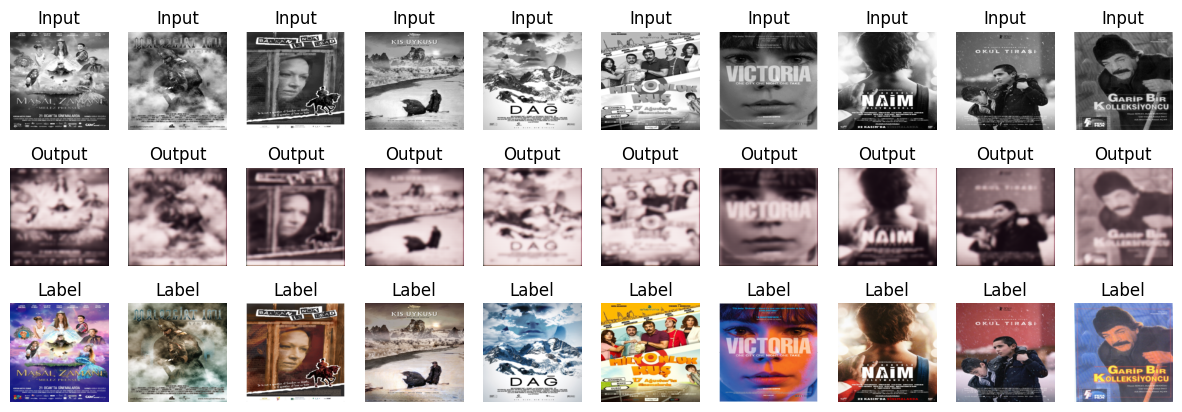

In [394]:
def visualize_examples(dataloader, model, device):
    model.eval()

    for batch in dataloader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)

        inputs_np = inputs.cpu().permute(0, 2, 3, 1).numpy()
        outputs_np = outputs.cpu().permute(0, 2, 3, 1).detach().numpy()
        labels_np = labels.cpu().permute(0, 2, 3, 1).numpy()

        plt.figure(figsize=(15, 5))
        for i in range(inputs_np.shape[0]):
            plt.subplot(3, inputs_np.shape[0], i + 1)
            plt.imshow(inputs_np[i], cmap='gray')
            plt.axis("off")
            plt.title("Input")

            plt.subplot(3, inputs_np.shape[0], i + 1 + inputs_np.shape[0])
            plt.imshow(outputs_np[i], cmap='gray')
            plt.axis("off")
            plt.title("Output")

            plt.subplot(3, inputs_np.shape[0], i + 1 + 2 * inputs_np.shape[0])
            plt.imshow(labels_np[i], cmap='gray')
            plt.axis("off")
            plt.title("Label")

        plt.show()
        break

visualize_examples(dataloader_val, loaded_model, device)

# Points:
# Problem:
# Colourization 1
# Model:
# Own architecture (over 50% of own layers) 2
# Other:
# Evaluation on a set with at least 10000 photos 1
# Testing a few optimizers (at least 3) 1